In [97]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, \
    roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pygam import LogisticGAM
from pygam.utils import generate_X_grid
from copy import copy
from progressbar import ProgressBar

# ROC Curves and AUC

In [2]:
df = pd.read_csv('marketing.csv')
X = pd.get_dummies(df.iloc[:,:-1]).values
y = np.where(df['y'] == 'yes', 1, 0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(30291, 27) (14920, 27)
(30291,) (14920,)


In [3]:
logit_clf = LogisticRegression(C=10e5)
logit_clf.fit(X_train, y_train)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [4]:
prob_pred = logit_clf.predict_proba(X_test)[:,1]
prob_pred_0 = logit_clf.predict_proba(
    X_test[np.where(y_test==0)])[:,1]
prob_pred_1 = logit_clf.predict_proba(
    X_test[np.where(y_test==1)])[:,1]
scores = np.log(prob_pred/(1-prob_pred))
scores_0 = np.log(prob_pred_0/(1-prob_pred_0))
scores_1 = np.log(prob_pred_1/(1-prob_pred_1))

## Histogram of Logit Scores

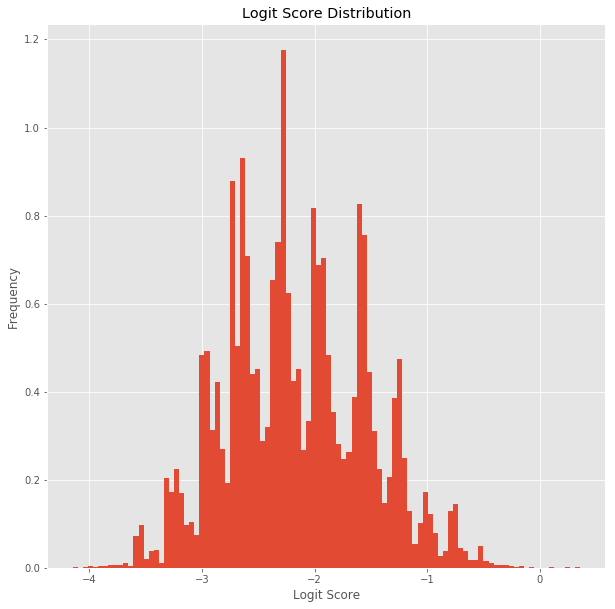

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
_ = ax.hist(scores, 100, normed=1)
_ = ax.update({'xlabel':'Logit Score', 'ylabel':'Frequency', 
           'title':'Logit Score Distribution'})

## Histogram of Logit Scores for Each Class

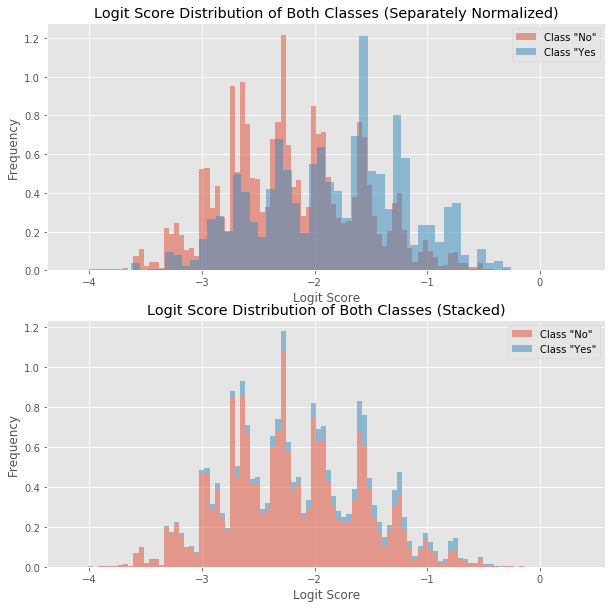

In [6]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,10))
ax1.hist(scores_0, bins=100, normed=1, alpha=0.5, label='Class "No"')
ax1.hist(scores_1, bins=50, normed=1, alpha=0.5, label='Class "Yes')
# Since we have unbalanced class labels, 
# let ax1 normalize them separately to make a nicer plot
ax2.hist([scores_0, scores_1], bins=100, 
         normed=1, stacked=1, alpha=0.5, label=['Class "No"', 'Class "Yes"'])
# ax2 normalizes the whole dataset to 1.
ax1.update({'xlabel':'Logit Score', 'ylabel':'Frequency', 
    'title':'Logit Score Distribution of Both Classes (Separately Normalized)'})
ax2.update({'xlabel':'Logit Score', 'ylabel':'Frequency', 
    'title':'Logit Score Distribution of Both Classes (Stacked)'})
ax1.legend()
_ = ax2.legend()

## True Positive and False Positive Rate

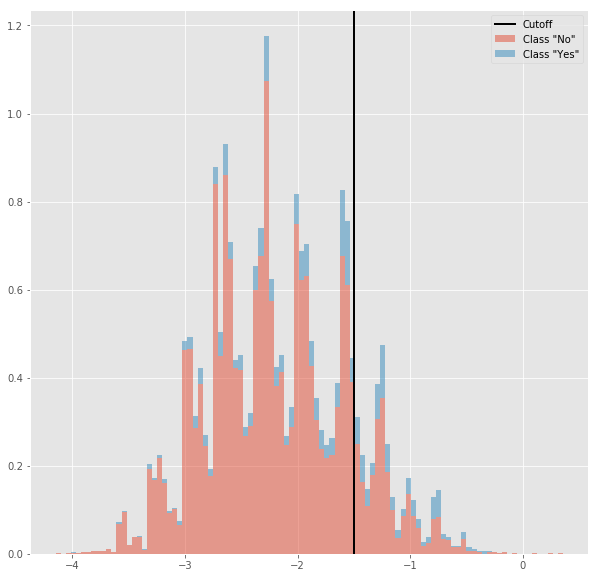

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.hist([scores_0, scores_1], bins=100, 
        normed=1, stacked=1, alpha=0.5, label=['Class "No"', 'Class "Yes"'])
ax.axvline(-1.5, color='black', linewidth=2, label='Cutoff')
ax2.update({'xlabel':'Logit Score', 'ylabel':'Frequency', 
    'title':'Logit Score Distribution of Both Classes with Cutoff'})
_ = ax.legend()


- True positive rate is the area of class "Yes" histogram that is on the **right** of the cutoff line.
- False positive rate is the area of class "No" histogram that is on the **right** of the cutoff line.

If we let $f_0(x)$ be the class "No" score distribution, $f_1(x)$ be that of class "Yes", we have:
$$
TPR(T) = \int_T^{\infty} f_1(x)dx
$$
$$
FPR(T) = \int_T^{\infty} f_0(x)dx
$$

## Area Under the Curve
As the hint suggests:
$$
\begin{split}
AUC &= \int_{\infty}^{-\infty} FPR(t) \cdot TPR'(t) dt \\
&= \int_{\infty}^{-\infty} \left( \int_t^{\infty} f_0(x)dx \right) \cdot (-f_1(t)) dt \\
&= \int_{-\infty}^{\infty} \left( \int_t^{\infty} f_0(x)dx \right) f_1(t) dt \\
\end{split}
$$

## Interpretation of Area Under the Curve
Let $S_0$ be the score of a random point from "No" class, $S_1$ be that from "Yes" class, then $S_0, S_1$ are random variables that have pdf $f_0(x)$ and $f_1(x)$. Therefore:
$$
\begin{split}
P(S_1>S_0) &= E[\mathbb{1}_{\{S_1 > S_0\}}] \\
&= E[E[\mathbb{1}_{\{S_1 > S_0\}} | S_1]] \\
&= \int_{-\infty}^{\infty}E[\mathbb{1}_{\{S_1 > S_0\}} | S_1=t]f_1(t)dt \\
&= \int_{-\infty}^{\infty}E[\mathbb{1}_{\{S_0 < t\}}]f_1(t)dt \\
&= \int_{-\infty}^{\infty}P(S_0 < t)f_1(t)dt \\
&=\int_{-\infty}^{\infty} \left( \int_t^{\infty} f_0(x)dx \right) f_1(t) dt \\
&=AUC
\end{split}
$$

# ROC Curve with Asymmetric 0-1 loss

## Evaluate Estimate

In [8]:
def eval_estimate(est, truth, loss_fp, loss_fn):
    # using np.sum is essential for speed
    n, p = len(est), np.sum(truth)
    fp = np.sum(est & (~truth))
    fn = np.sum(truth & (~est))
    tp = p - fn
    tn = n - p - fp
    sens = tp/p
    spec = tn/(n-p)
    loss = loss_fp*fp + loss_fn*fn
    return sens, spec, loss

In [9]:
# check on the scores from logistic regression
sens, spec, loss = eval_estimate(
    scores > -1,
    y_test.astype(bool),
    loss_fp=5,
    loss_fn=100
)
print("""
Sensitivity: {},
Specificity: {},
Total Loss: {}.
""".format(sens, spec, loss))


Sensitivity: 0.09883720930232558,
Specificity: 0.9731818181818181,
Total Loss: 156770.



## ROC Curve

In [10]:
unique_values = np.sort(np.unique(scores))
midpoints = (unique_values[0:(len(unique_values)-1)]+
             unique_values[1:len(unique_values)])/2.0
sens_path, spec_path, loss_path = np.vectorize( lambda x: eval_estimate(
    scores>x,np.array(y_test, dtype=bool), 5, 100))(midpoints)

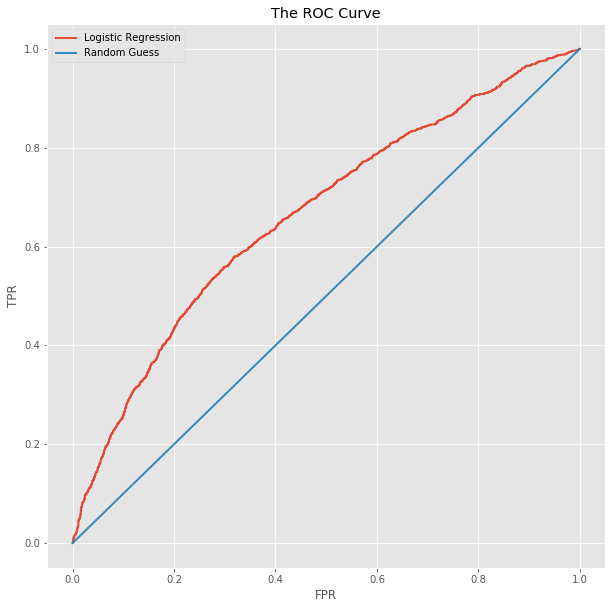

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(1-spec_path, sens_path, linewidth=2,
        label='Logistic Regression')
ax.plot([0,1], [0,1], linewidth=2,
        label='Random Guess')
ax.update({'xlabel':'FPR', 'ylabel':'TPR', 
           'title':'The ROC Curve'})
_ = ax.legend()

## Loss on the ROC

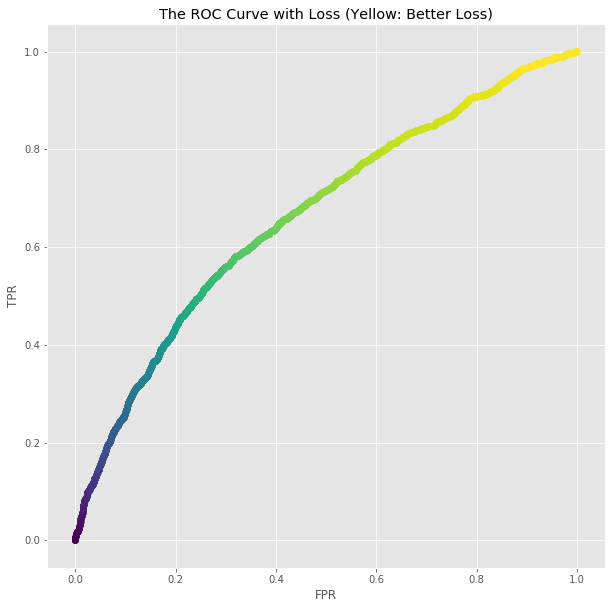

In [12]:
from matplotlib import cm #For nice colors
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.scatter(1-spec_path, sens_path, c=-loss_path, label='ROC')
_ = ax.update({
    'xlabel':'FPR', 'ylabel':'TPR', 
    'title':'The ROC Curve with Loss (Yellow: Better Loss)'})

## Minimum Loss and Tangent Line

In [13]:
def attach_abline(ax, slope, intercept, label=None):
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', label=label)
    return ax

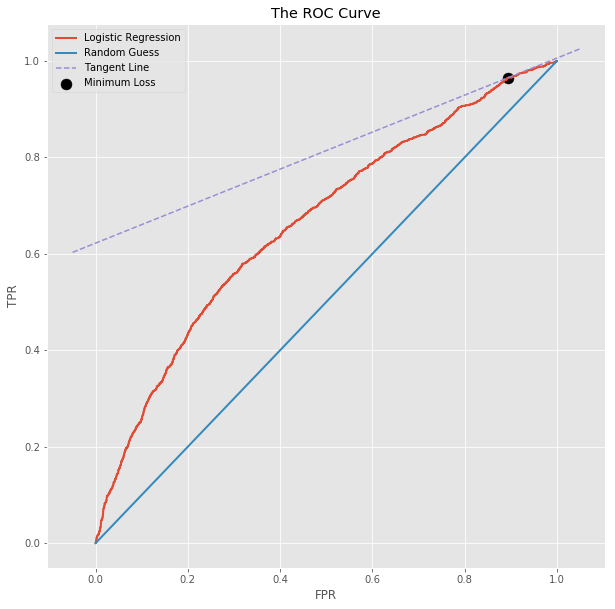

In [14]:
best_idx = np.argmin(loss_path)
slope = ((len(y_test)-np.sum(y_test))/(
    np.sum(y_test))) * (5/100)
best_fpr, best_tpr = 1-spec_path[best_idx], sens_path[best_idx]
intercept = best_tpr - best_fpr*slope

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(1-spec_path, sens_path, linewidth=2,
        label='Logistic Regression')
ax.plot([0,1], [0,1], linewidth=2,
        label='Random Guess')
ax.scatter(best_fpr, best_tpr, s=120, 
           color='black', label="Minimum Loss")
ax = attach_abline(ax, slope, intercept, 'Tangent Line')
ax.update({'xlabel':'FPR', 'ylabel':'TPR', 
           'title':'The ROC Curve'})
_ = ax.legend()

We notice that the line which passes through the minimum-loss point with a slope of $\frac{N}{P}\frac{L_{FP}}{L_{FN}}$ is tangent to the ROC curve.

## Proof
By definition, $FPR = \frac{FP}{N}$, $FNR=\frac{FN}{P}$

$$
\begin{split}
\mathcal{L}(T) &= L_{FP}\cdot FP + L_{FN}\cdot FN \\
&= L_{FP}\cdot N \cdot FPR + L_{FN}\cdot P \cdot FNR \\
&= L_{FP}\cdot N \cdot FPR + L_{FN}\cdot P \cdot (1-TPR) \\
&= L_{FP}\cdot N \int_T^{\infty} f_0(x)dx + L_{FN}\cdot P \int_{-\infty}^{T} f_1(x)dx
\end{split}
$$

The first order condition:

$$
\begin{split}
\frac{\partial}{\partial T}\mathcal{L}(T) &= -L_{FP}\cdot N f_0(T) + L_{FN}\cdot P f_1(T) = 0\\
\Rightarrow ~~~~\frac{f_1(T)}{f_0(T)} &= \frac{L_{FP} N }{L_{FN} P}
\end{split}
$$

# Continue the Last Problem

## Optimal Cutoff
Last time we derived that the optimal probability threshold is
$$
T^* = \frac{L_{01}}{L_{01}+L_{10}} = \frac{L_{FP}}{L_{FP}+L_{FN}} = \frac{5}{105}
$$


In [15]:
sens, spec, loss_opt = eval_estimate(
    prob_pred > 5/105,
    y_test.astype(bool),
    loss_fp=5,
    loss_fn=100
)
print("""
Using optimal threshold T_star = 5/105
Sensitivity: {},
Specificity: {},
Total Loss: {}.
""".format(sens, spec, loss_opt))

print('Minimum loss on ROC: {}'.format(min(loss_path)))


Using optimal threshold T_star = 5/105
Sensitivity: 0.975,
Specificity: 0.07659090909090908,
Total Loss: 65245.

Minimum loss on ROC: 64950


The Minimum loss on ROC is a bit smaller than that using the optimal cutoff threshold, but they are very close.

## $T^*$ on ROC

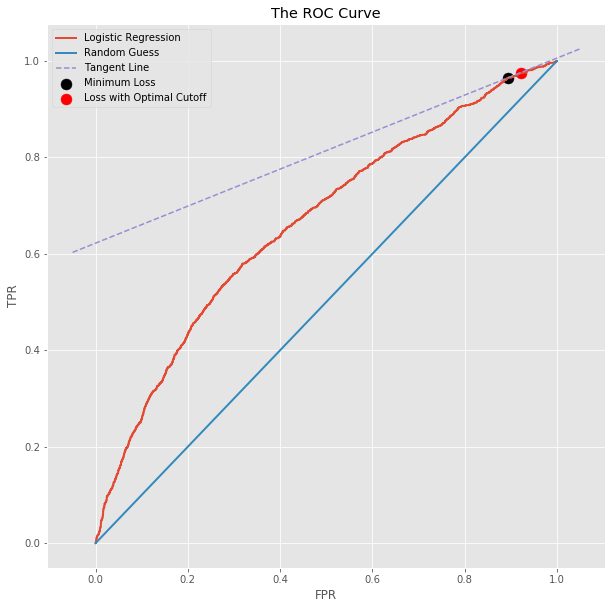

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(1-spec_path, sens_path, linewidth=2,
        label='Logistic Regression')
ax.plot([0,1], [0,1], linewidth=2,
        label='Random Guess')
ax.scatter(best_fpr, best_tpr, s=120, 
           color='black', label="Minimum Loss")
ax.scatter(1-spec, sens, s=120, 
           color='red', label="Loss with Optimal Cutoff")
ax = attach_abline(ax, slope, intercept, 'Tangent Line')
ax.update({'xlabel':'FPR', 'ylabel':'TPR', 
           'title':'The ROC Curve'})
_ = ax.legend()

The point with ideal cutoff value is a little higher on the ROC curve than the true minimum, but they are very close, too. 

The reason why these two do not completely agree is that the ideal cutoff value is chosen such that the **Expected** Prediction Loss is minimized. This means that if we draw many dataset from the underlying distribution, their average loss is minimized using $T^*$ as decision threshold. In practice we only have one dataset, it's very natural for the prediction loss to  deviate from the expectation, maybe a lot.

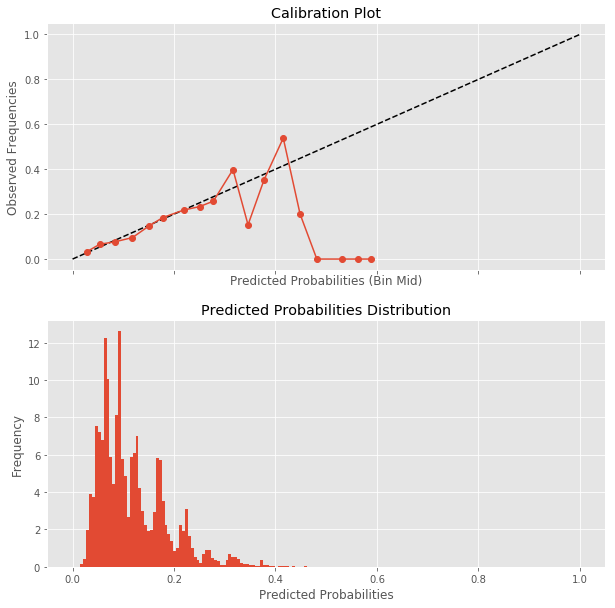

In [54]:
prob_true_clb, prob_pred_clb = calibration_curve(
    y_test, prob_pred, normalize=False, n_bins=30)

fig, (ax1,ax2) = plt.subplots(
    2,1, figsize=(10,10),sharex='col')
ax1.plot([0,1], [0,1], '--', color='black')
ax1.plot(prob_pred_clb, prob_true_clb, 'o-')
_ = ax1.update({
    'xlabel':'Predicted Probabilities (Bin Mid)', 
    'ylabel':'Observed Frequencies', 
    'title':'Calibration Plot'})
ax2.hist(prob_pred, 100, normed=1)
_ = ax2.update({'xlabel':'Predicted Probabilities', 'ylabel':'Frequency', 
    'title':'Predicted Probabilities Distribution'})

The classifier is well-calibrated at small $\hat{p}(x)$'s, namely between 0 and 0.3. It has poor calibration at large $\hat{p}(x)$ area, those after 0.3.

The reason is that the dataset is mostly distributed between 0 and 0.3, after that there is only a few data points. Therefore the observed frequency is a very poor estimate of true $p(x)$ in this part, and it has high variance. So the predicted probability does not match to the observed frequency.


## ROC for Logistic GAM

In [55]:
%%capture --no-stdout --no-display

gam_clf = LogisticGAM().gridsearch(
    X_train, y_train)

prob_pred_gam = gam_clf.predict_proba(X_test)
scores_gam = np.log(prob_pred_gam/(1-prob_pred_gam))

100% (11 of 11) |#########################| Elapsed Time: 0:00:58 Time: 0:00:58


In [56]:
unique_values_gam = np.sort(np.unique(scores_gam))
midpoints_gam = (unique_values_gam[0:(len(unique_values_gam)-1)]+
             unique_values_gam[1:len(unique_values_gam)])/2.0
sens_path_gam, spec_path_gam, loss_path_gam = np.vectorize( 
    lambda x: eval_estimate(
    scores_gam>x,np.array(y_test, dtype=bool), 5, 100))(midpoints_gam)

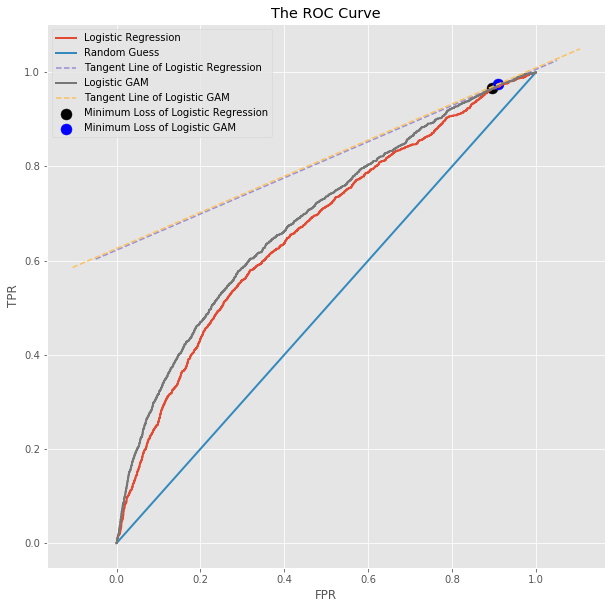

In [59]:
best_idx = np.argmin(loss_path)
slope = ((len(y_test)-np.sum(y_test))/(
    np.sum(y_test))) * (5/100)
best_fpr, best_tpr = 1-spec_path[best_idx], sens_path[best_idx]
intercept = best_tpr - best_fpr*slope

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(1-spec_path, sens_path, linewidth=2,
        label='Logistic Regression')
ax.plot([0,1], [0,1], linewidth=2,
        label='Random Guess')
ax.scatter(best_fpr, best_tpr, s=120, 
           color='black', label="Minimum Loss of Logistic Regression")
ax = attach_abline(
    ax, slope, intercept, 'Tangent Line of Logistic Regression')
ax.update({'xlabel':'FPR', 'ylabel':'TPR', 
           'title':'The ROC Curve'})

best_idx = np.argmin(loss_path_gam)
slope = ((len(y_test)-np.sum(y_test))/(
    np.sum(y_test))) * (5/100)
best_fpr, best_tpr = 1-spec_path_gam[best_idx], sens_path_gam[best_idx]
intercept = best_tpr - best_fpr*slope
ax.plot(1-spec_path_gam, sens_path_gam, linewidth=2,
        label='Logistic GAM')
ax.scatter(best_fpr, best_tpr, s=120, 
           color='blue', label="Minimum Loss of Logistic GAM")
ax = attach_abline(
    ax, slope, intercept, 'Tangent Line of Logistic GAM')


_ = ax.legend()

The minimum loss point of GAM is slightly higher than that of Logistic regression on the ROC curve, so is the tangent line. But they are still very close to each other.

# Classifying Fraudulent Banknotes

In [87]:
df_banknote = pd.read_csv('banknote_measurements.csv', index_col=0)
X = df_banknote.iloc[:,1:].values
y = np.where(df_banknote['counterfeit'] == 'counterfeit', 1, 0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5,random_state=1)
X_names = list(df_banknote.columns)[1:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(100, 5) (100, 5)
(100,) (100,)


## Histogram of Features

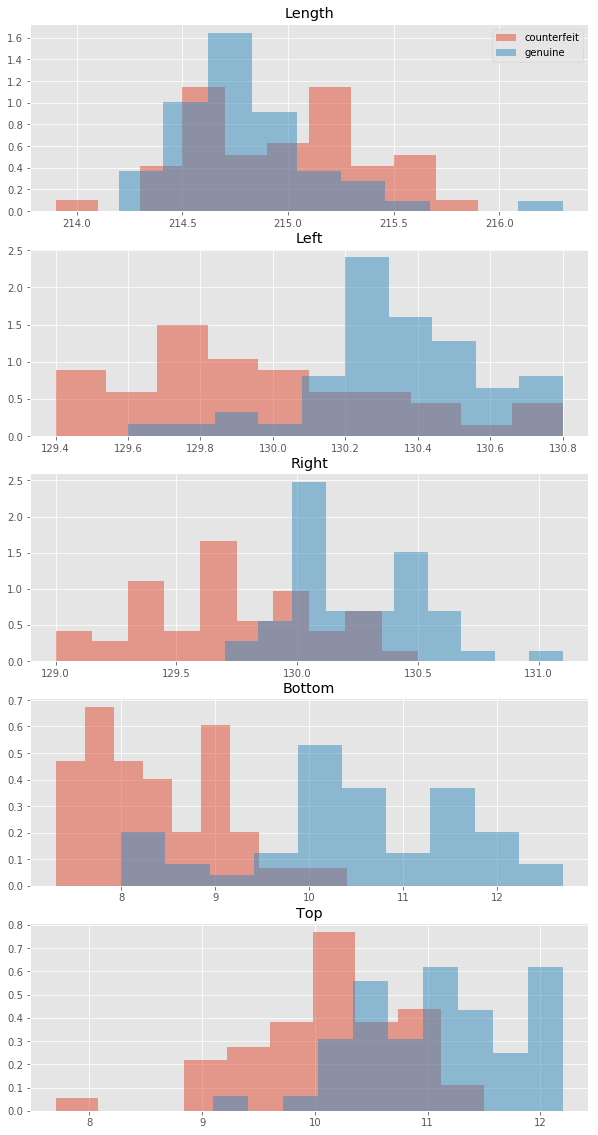

In [96]:
fig, axes = plt.subplots(5,1, figsize=(10,20))
for i, name in enumerate(X_names):
    axes[i].hist(X_test[:,i][y_test==0], bins=10,
        normed=1, alpha=0.5, label='counterfeit')
    axes[i].hist(X_test[:,i][y_test==1], bins=10,
        normed=1, alpha=0.5, label='genuine')
    axes[i].update({'title':name})
_ = axes[0].legend()

None of these features perfectly separate the two classes.

## LDA Fit and Confusion Matrix

In [115]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
misclf = 1-accuracy_score(y_test, y_pred, normalize=1)
print('LDA Misclassification Rate: ', misclf)
print('Confusion Matrix:')
confusion_matrix(y_test, y_pred)

LDA Misclassification Rate:  0.07
Confusion Matrix:


array([[47,  1],
       [ 6, 46]])

## LDA Transformed Feature

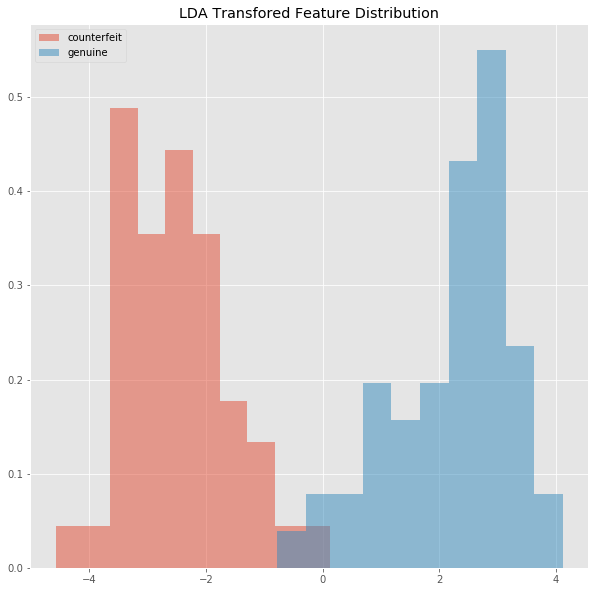

In [113]:
X_transformed = lda.transform(X_test)
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.hist(X_transformed[y_test==0], bins=10,
    normed=1, alpha=0.5, label='counterfeit')
ax.hist(X_transformed[y_test==1], bins=10,
    normed=1, alpha=0.5, label='genuine')
ax.update({'title': "LDA Transfored Feature Distribution"})
_ = ax.legend()

The LDA transformation separates the data a lot better than any of the single feature.